# 🧪 Tox21 Classical ML Baseline with Molecular Fingerprints

This notebook demonstrates how to use classical machine learning models (e.g., Random Forest) with ECFP (Morgan) fingerprints on the Tox21 dataset.

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data/tox21.csv")
print(df.columns)
df.head()

Index(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
       'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
       'mol_id', 'smiles'],
      dtype='object')


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In [31]:
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None and mol.GetNumAtoms() > 0

# Keep only valid rows
df = df[df['smiles'].apply(is_valid_smiles)].reset_index(drop=True)

[19:35:40] WARNING: not removing hydrogen atom without neighbors


1. `Chem.MolFromSmiles(smiles)`:
* This is an RDK utility that parses a SMILES string and attempts to convert it into a molecule object (mol)
* If the SMILES is malformed or invalid, it returns `None`.

2. mol is not None:
* Ensures that the parsing succeded (i.e. the SMILES was valid enough to generate a molecule object).

3. mol.GetNumAtoms() > 0:
* Additional check to ensure that the molecule has at least one atom. Some valid SMILES could technically yield an empty molecule (rare but possible), so this filters those out too

In [4]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# Define generator only once
morgan_gen = GetMorganGenerator(radius=2, fpSize=1024)

def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((morgan_gen.GetNumBits(),))
    return np.array(morgan_gen.GetFingerprint(mol))

* GetMorganGenerator(radius=2, fpSize=1024) creates a fingerprint generator:
    * radius=2: Neighborhood radius (like ECFP4)
    * fpSize=1024: Output vector length (bit vector)



This generator is efficient - defined once and reused to avoid overhead

* Function: `smiles_to_ecfp`
1. Parses the SMILES to create an RDKit molecule
2. If invalid (mol is None), returns a zero-filled fingerprint vector (failsafe fallback)
3. If valid, generates the Morgan fingerprint and returns it as a NumPy array.

* Output Shape:
* Always returns a 1D NumPy array of length 1024 (as defined by fpSize)

In [5]:
# def smiles_to_ecfp(smiles, radius=2, nBits=1024):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return np.zeros((nBits,))
#     return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

X = np.array([smiles_to_ecfp(s) for s in df['smiles']])

[10:36:19] WARNING: not removing hydrogen atom without neighbors


In [6]:
target = 'NR-AR'  # or any of the 12 Tox21 targets
y = df[target]
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]

# What this code does

1. Selects a target label to predict ('NR-AR')
2. `Removes rows with missing labels` - only keeps molecules where the target value is known.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

## Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

## Train/test split and ROC-AUC evaluation for one target ('NR-AR')

In [9]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.725144312393888
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1425
         1.0       0.96      0.37      0.53        62

    accuracy                           0.97      1487
   macro avg       0.97      0.69      0.76      1487
weighted avg       0.97      0.97      0.97      1487



## Scale to All 12 Tox21 Targets
Currently, the model is train on a single target (NR-AR). The next major step is to loop over all 12 targets, train separate models, and report performance metrics per target

In [10]:
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

results = {}

for target in targets:
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results[target] = auc
    print(f"{target} ROC-AUC: {auc:.4f}")


NR-AR ROC-AUC: 0.7251
NR-AR-LBD ROC-AUC: 0.8214
NR-AhR ROC-AUC: 0.8878
NR-Aromatase ROC-AUC: 0.7703
NR-ER ROC-AUC: 0.7065
NR-ER-LBD ROC-AUC: 0.7774
NR-PPAR-gamma ROC-AUC: 0.7856
SR-ARE ROC-AUC: 0.7620
SR-ATAD5 ROC-AUC: 0.8188
SR-HSE ROC-AUC: 0.8187
SR-MMP ROC-AUC: 0.8247
SR-p53 ROC-AUC: 0.8251


🧠 Purpose

This code trains separate Random Forest Classifiers for each of the 12 Tox21 toxicity prediction tasks (each task corresponds to a different biological target), and reports how well each model performs using the ROC-AUC metric.

## Plot test using both matplotlib and seaborn

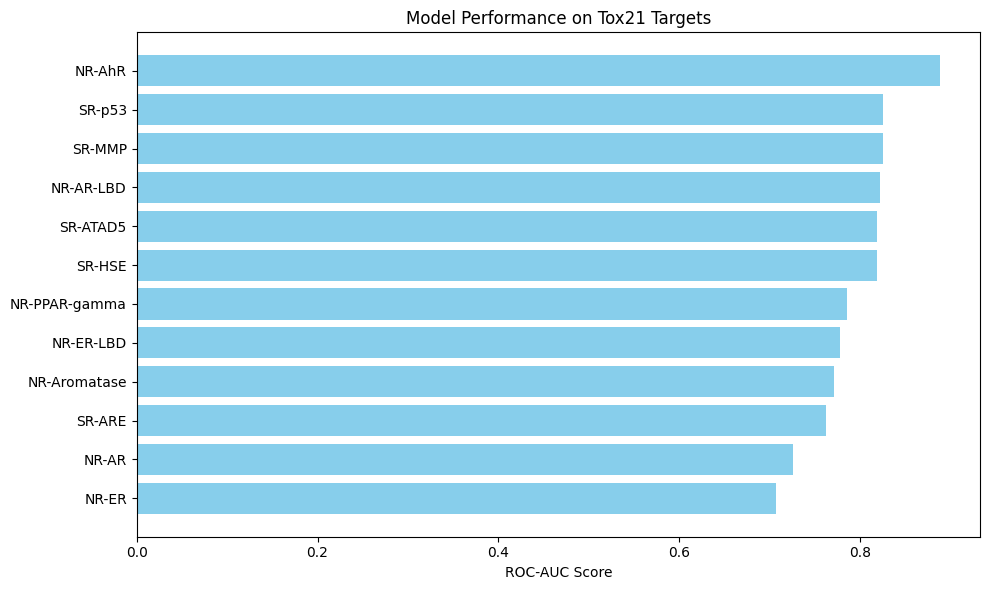

In [11]:
# Using matplot lib
import matplotlib.pyplot as plt

# Sort results by AUC score (optional for better visuals)
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='skyblue')
plt.xlabel("ROC-AUC Score")
plt.title("Model Performance on Tox21 Targets")
plt.gca().invert_yaxis()  # highest score on top
plt.tight_layout()
plt.show()


* Sort the results dictionary by AUC score, from highest to lowest. Making the plot easier to interpret, with better-performing models at the top

# Using Random Forest to determine the ROC-AUC target for each Tox21 target

/var/folders/27/1nzvqhpd5f7bc_n8rgyv1v4h0000gn/T/ipykernel_85099/1745266277.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ROC_AUC", y="Target", data=results_df, palette="viridis")


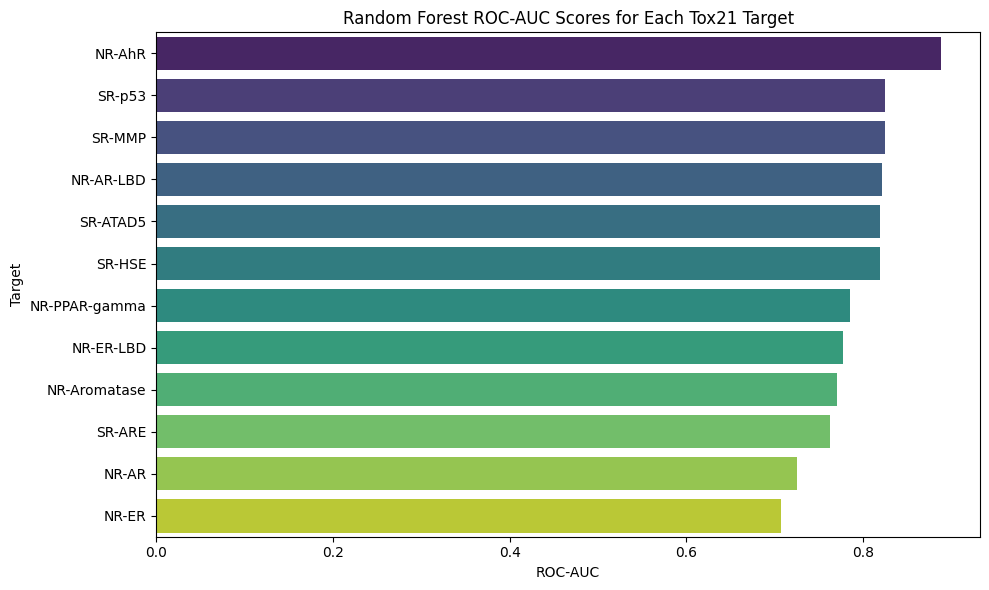

In [12]:
# Using seaborn library

import seaborn as sns
import pandas as pd

# Convert to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Target", "ROC_AUC"])
results_df = results_df.sort_values(by="ROC_AUC", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="ROC_AUC", y="Target", data=results_df, palette="viridis")
plt.title("Random Forest ROC-AUC Scores for Each Tox21 Target")
plt.xlabel("ROC-AUC")
plt.ylabel("Target")
plt.tight_layout()
plt.show()


# XGBoost for All 12 Targets
Setting up XGBoost baseline for all 12 Tox21 targets, using the same ECFP4 features computed. Compare performance between Random Forest and Gradient Boosting

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

In [15]:
from xgboost import XGBClassifier
print("XGBoost works!")


XGBoost works!


In [16]:
xgb_results = {}
for target in targets:
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
    )
    
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    xgb.fit(X_train, y_train)
    y_proba = xgb.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    xgb_results[target] = auc
    print(f"[XGBoost] {target} ROC-AUC: {auc:.4f}")

/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-AR ROC-AUC: 0.7362


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-AR-LBD ROC-AUC: 0.8415


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-AhR ROC-AUC: 0.8769


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-Aromatase ROC-AUC: 0.7787


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-ER ROC-AUC: 0.6972


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-ER-LBD ROC-AUC: 0.7531


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] NR-PPAR-gamma ROC-AUC: 0.7650


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] SR-ARE ROC-AUC: 0.7743


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] SR-ATAD5 ROC-AUC: 0.7995


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] SR-HSE ROC-AUC: 0.7767


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] SR-MMP ROC-AUC: 0.8430


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGBoost] SR-p53 ROC-AUC: 0.8287


## Plot Comparison Against Random Forest

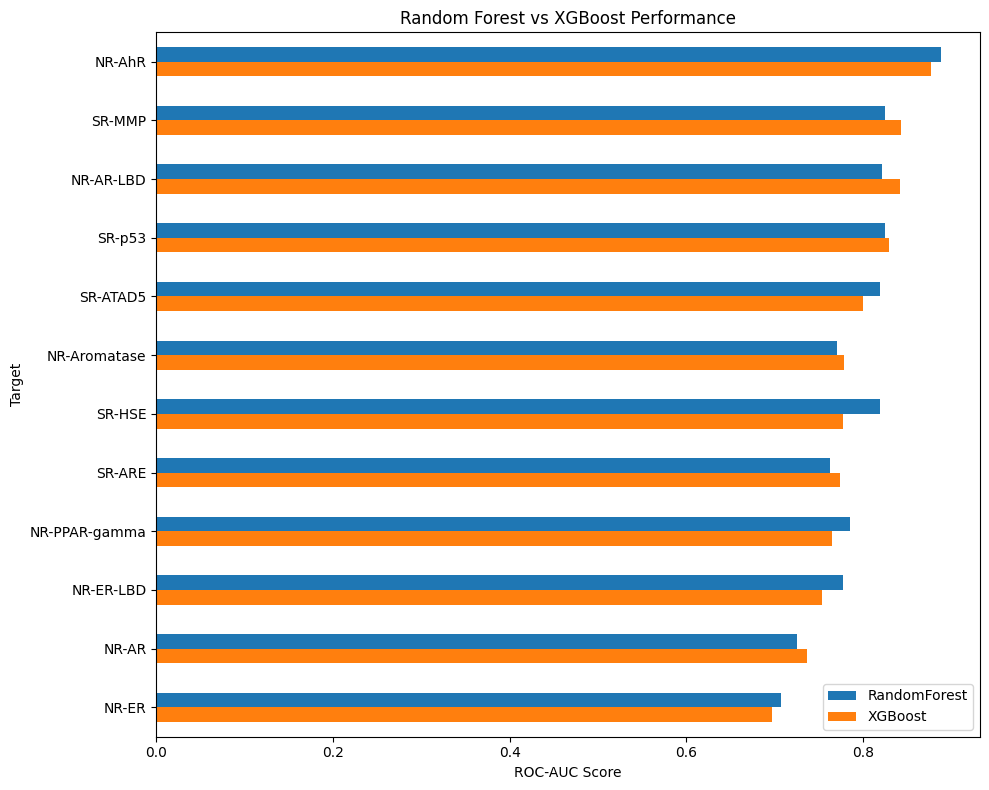

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine into one DataFrame
df_compare = pd.DataFrame({
    'Target': list(xgb_results.keys()),
    'RandomForest': [results[t] for t in xgb_results.keys()],
    'XGBoost': [xgb_results[t] for t in xgb_results.keys()]
})

df_compare = df_compare.sort_values('XGBoost', ascending=False)

# Plot
df_compare.plot(x='Target', kind='barh', figsize=(10, 8))
plt.xlabel("ROC-AUC Score")
plt.title("Random Forest vs XGBoost Performance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


## Use Cross-Validation instead of Single Train/Test Split
* Using Stratified K-Fold Cross-Validation to get more stable performance estimates
* Average metrics across folds for each target

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 12 Tox21 targets
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

rf_cv_results = {}

# Loop through each target
for target in targets:
    print(f"\nRunning CV for: {target}")
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_aucs = []

    for train_idx, test_idx in skf.split(X_clean, y_clean):
        X_train, X_test = X_clean[train_idx], X_clean[test_idx]
        y_train, y_test = y_clean[train_idx], y_clean[test_idx]

        clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        fold_aucs.append(auc)

    mean_auc = np.mean(fold_aucs)
    rf_cv_results[target] = mean_auc
    print(f"Mean ROC-AUC for {target}: {mean_auc:.4f}")



Running CV for: NR-AR
Mean ROC-AUC for NR-AR: 0.7812

Running CV for: NR-AR-LBD
Mean ROC-AUC for NR-AR-LBD: 0.8648

Running CV for: NR-AhR
Mean ROC-AUC for NR-AhR: 0.8809

Running CV for: NR-Aromatase
Mean ROC-AUC for NR-Aromatase: 0.8091

Running CV for: NR-ER
Mean ROC-AUC for NR-ER: 0.7188

Running CV for: NR-ER-LBD
Mean ROC-AUC for NR-ER-LBD: 0.7861

Running CV for: NR-PPAR-gamma
Mean ROC-AUC for NR-PPAR-gamma: 0.7793

Running CV for: SR-ARE
Mean ROC-AUC for SR-ARE: 0.7695

Running CV for: SR-ATAD5
Mean ROC-AUC for SR-ATAD5: 0.7943

Running CV for: SR-HSE
Mean ROC-AUC for SR-HSE: 0.7605

Running CV for: SR-MMP
Mean ROC-AUC for SR-MMP: 0.8542

Running CV for: SR-p53
Mean ROC-AUC for SR-p53: 0.8088


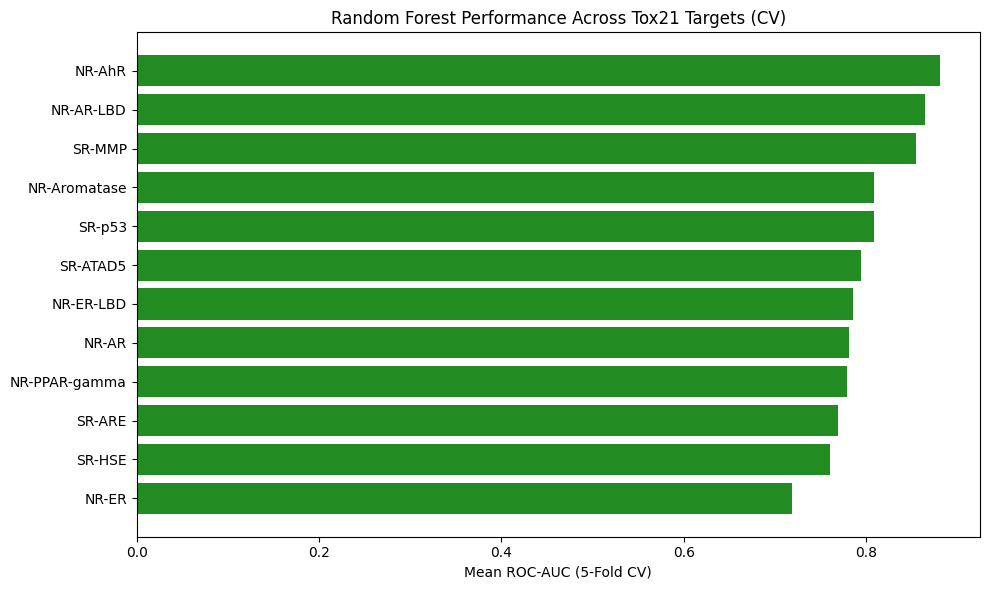

In [19]:
import matplotlib.pyplot as plt

# Sort results
sorted_rf_cv = dict(sorted(rf_cv_results.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_rf_cv.keys()), list(sorted_rf_cv.values()), color='forestgreen')
plt.xlabel("Mean ROC-AUC (5-Fold CV)")
plt.title("Random Forest Performance Across Tox21 Targets (CV)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


1. Train/Test Split (Initial method)
* Split data once: 80% for training, 20% for testing
* Quick and simple
* Works fine for an initial baseline.

* Drawbacks
    * Results can vary a lot depending on which 20% gets chosen
    * Might get lucky or unlucky with that split
    * May not reflect real-world generalization if dataset is small or imbalanced

2. Cross-Validation (e.g., Stratified K-Fold)
* Splits the dataset into K folds (e.g., 5)
* Trains the model K times, each time using a different fold as the test set
* Averages the performance across the K runs

🔥 XGBoost with Stratified K-Fold (All Targets)

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

In [22]:
xgb_cv_results = {}

targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

In [23]:
for target in targets:
    print(f"\nRunning XGBoost CV for: {target}")
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_aucs = []

    for train_idx, test_idx in skf.split(X_clean, y_clean):
        X_train, X_test = X_clean[train_idx], X_clean[test_idx]
        y_train, y_test = y_clean[train_idx], y_clean[test_idx]

        xgb = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        xgb.fit(X_train, y_train)
        y_proba = xgb.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        fold_aucs.append(auc)

    mean_auc = np.mean(fold_aucs)
    xgb_cv_results[target] = mean_auc
    print(f"Mean ROC-AUC for {target}: {mean_auc:.4f}")


Running XGBoost CV for: NR-AR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-AR: 0.7662

Running XGBoost CV for: NR-AR-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-AR-LBD: 0.8548

Running XGBoost CV for: NR-AhR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-AhR: 0.8867

Running XGBoost CV for: NR-Aromatase


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-Aromatase: 0.7960

Running XGBoost CV for: NR-ER


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-ER: 0.7156

Running XGBoost CV for: NR-ER-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-ER-LBD: 0.7775

Running XGBoost CV for: NR-PPAR-gamma


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for NR-PPAR-gamma: 0.7771

Running XGBoost CV for: SR-ARE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for SR-ARE: 0.7871

Running XGBoost CV for: SR-ATAD5


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for SR-ATAD5: 0.8254

Running XGBoost CV for: SR-HSE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for SR-HSE: 0.7482

Running XGBoost CV for: SR-MMP


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for SR-MMP: 0.8676

Running XGBoost CV for: SR-p53


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Mean ROC-AUC for SR-p53: 0.8208


## Side-by-Side Comparison with Random Forest Classifier

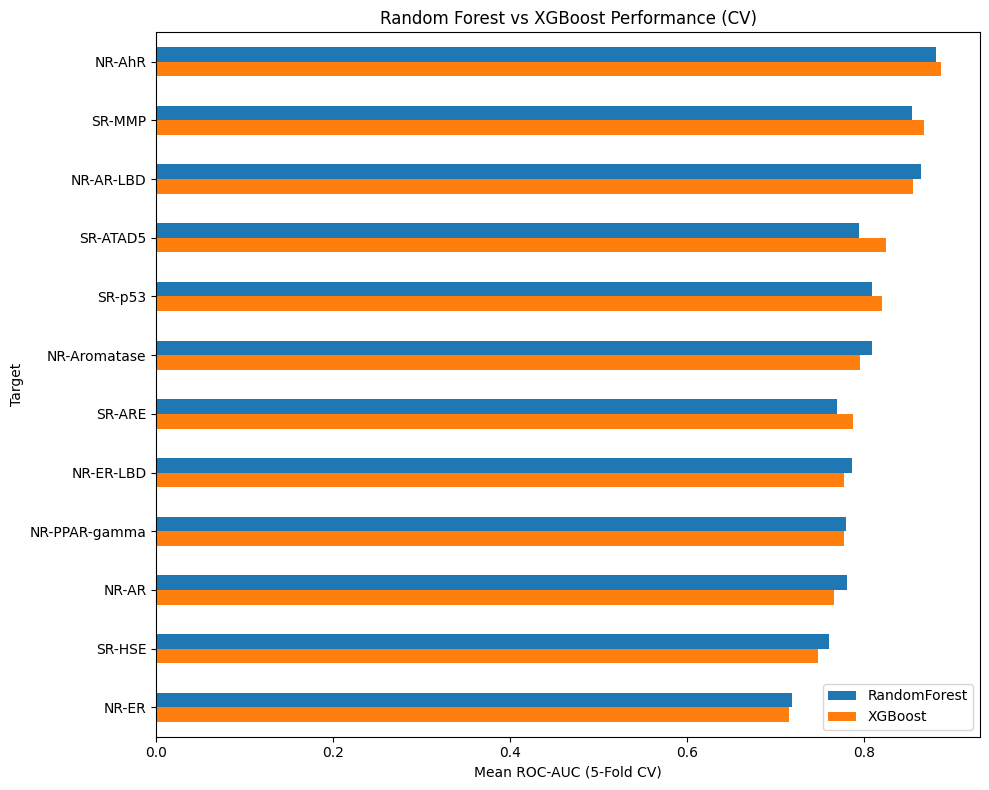

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df_compare = pd.DataFrame({
    'Target': list(rf_cv_results.keys()),
    'RandomForest': [rf_cv_results[t] for t in rf_cv_results.keys()],
    'XGBoost': [xgb_cv_results[t] for t in xgb_cv_results.keys()]
})

df_compare = df_compare.sort_values("XGBoost", ascending=False)

# Plotting side-by-side
df_compare.plot(x='Target', kind='barh', figsize=(10, 8))
plt.xlabel("Mean ROC-AUC (5-Fold CV)")
plt.title("Random Forest vs XGBoost Performance (CV)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## Calculate & Display Performance Gains

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine results into a DataFrame
df_diff = pd.DataFrame({
    'Target': list(rf_cv_results.keys()),
    'RandomForest': [rf_cv_results[t] for t in rf_cv_results.keys()],
    'XGBoost': [xgb_cv_results[t] for t in rf_cv_results.keys()]
})

# Compute the performance gain
df_diff['Gain_XGB_vs_RF'] = df_diff['XGBoost'] - df_diff['RandomForest']

# Sort by gain
df_diff_sorted = df_diff.sort_values('Gain_XGB_vs_RF', ascending=False)

# Display the top gains
print("Top targets where XGBoost outperforms Random Forest:")
print(df_diff_sorted.head())

Top targets where XGBoost outperforms Random Forest:
      Target  RandomForest   XGBoost  Gain_XGB_vs_RF
8   SR-ATAD5      0.794260  0.825353        0.031094
7     SR-ARE      0.769497  0.787140        0.017643
10    SR-MMP      0.854191  0.867627        0.013436
11    SR-p53      0.808773  0.820767        0.011994
2     NR-AhR      0.880867  0.886739        0.005873


### Plot the gains

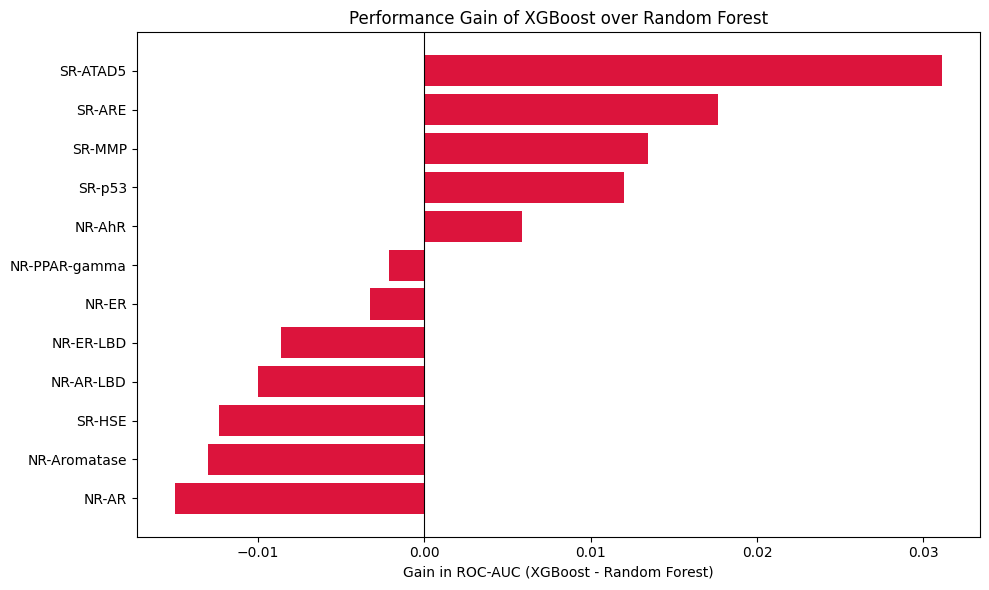

In [26]:
# Plotting the performance gain
plt.figure(figsize=(10, 6))
plt.barh(df_diff_sorted['Target'], df_diff_sorted['Gain_XGB_vs_RF'], color='crimson')
plt.xlabel("Gain in ROC-AUC (XGBoost - Random Forest)")
plt.title("Performance Gain of XGBoost over Random Forest")
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Comparing statistical significance (Random Forest vs XGBoost) result across Tox21 targets

In [27]:
rf_folds = {}

for target in targets:
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, test_idx in skf.split(X_clean, y_clean):
        X_train, X_test = X_clean[train_idx], X_clean[test_idx]
        y_train, y_test = y_clean[train_idx], y_clean[test_idx]

        clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
    rf_folds[target] = aucs

In [28]:
# Modify CV code to store fold scores for XGBoost
xgb_folds = {}

for target in targets:
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, test_idx in skf.split(X_clean, y_clean):
        X_train, X_test = X_clean[train_idx], X_clean[test_idx]
        y_train, y_test = y_clean[train_idx], y_clean[test_idx]

        xgb = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        xgb.fit(X_train, y_train)
        y_proba = xgb.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
    xgb_folds[target] = aucs

/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:07:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:07:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

In [29]:
from scipy.stats import ttest_rel, wilcoxon

stat_results = []

for target in targets:
    rf_scores = rf_folds[target]
    xgb_scores = xgb_folds[target]

    # Paired t-test
    t_stat, t_p = ttest_rel(xgb_scores, rf_scores)

    # Wilcoxon test (non-parametric alternative)
    try:
        w_stat, w_p = wilcoxon(xgb_scores, rf_scores)
    except:
        w_stat, w_p = (None, None)  # In case of errors (e.g., all scores equal)

    stat_results.append({
        "Target": target,
        "RF_Mean_AUC": round(np.mean(rf_scores), 4),
        "XGB_Mean_AUC": round(np.mean(xgb_scores), 4),
        "T-test p-value": round(t_p, 4),
        "Wilcoxon p-value": round(w_p, 4) if w_p is not None else None
    })

df_stats = pd.DataFrame(stat_results).sort_values("T-test p-value")
print(df_stats)


           Target  RF_Mean_AUC  XGB_Mean_AUC  T-test p-value  Wilcoxon p-value
8        SR-ATAD5       0.7943        0.8254          0.0203            0.0625
10         SR-MMP       0.8542        0.8676          0.0221            0.0625
7          SR-ARE       0.7695        0.7871          0.0273            0.0625
3    NR-Aromatase       0.8091        0.7960          0.0746            0.1250
11         SR-p53       0.8088        0.8208          0.1643            0.1875
2          NR-AhR       0.8809        0.8867          0.1993            0.3125
1       NR-AR-LBD       0.8648        0.8548          0.2223            0.1875
0           NR-AR       0.7812        0.7662          0.2576            0.1875
5       NR-ER-LBD       0.7861        0.7775          0.3889            0.3125
9          SR-HSE       0.7605        0.7482          0.4636            0.6250
4           NR-ER       0.7188        0.7156          0.6325            0.6250
6   NR-PPAR-gamma       0.7793        0.7771        

📈 RF_Mean_AUC & XGB_Mean_AUC
* These are the average ROC-AUC scores across 5 CV folds for each model.
* This tells which model performed better on average for each task

🧪 T-test p-value
* This tests whether the mean AUCs from the two models are significantly different
* If the p-value is < 0.05, the difference is statistically significant - meaning the improvement is unlikely due to chance

📊 Wilcoxon p-value
* This is a non-parametric version of the test. It's safer when you have:
    * Small sample sizes (like 5 folds)
    * Scores that aren't normally distributed

Interpretation is the same:
* `< 0.05` -> Significant
* `> 0.05` -> Not statistically significant
* None of the Wilcoxon p-values are < 0.05, but some (like SR-ATAD5, SR-ARE, SR-MMP) are close (≈0.0625)

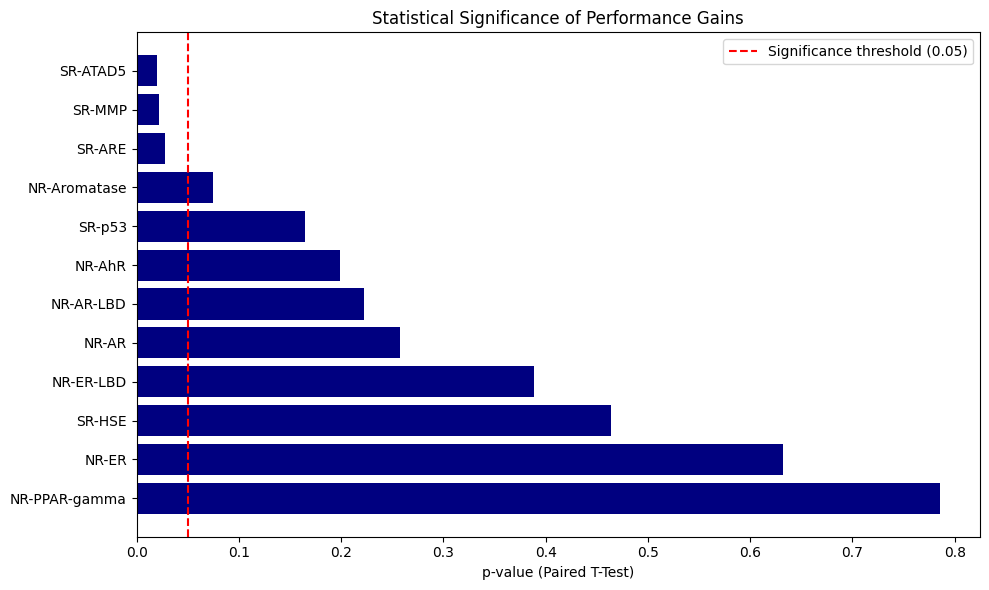

In [30]:
plt.figure(figsize=(10, 6))
plt.barh(df_stats['Target'], df_stats['T-test p-value'], color='navy')
plt.axvline(0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
plt.xlabel("p-value (Paired T-Test)")
plt.title("Statistical Significance of Performance Gains")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()



✅ Bars to the left of the red line (p-value < 0.05):
* Statistically significant
* XGBoost performed meaningfully better than Random Forest
* The difference is unlikely due to random variation 

- In the graph, 'ST-ATAD5', 'SR-MMP', 'SR-ARE' are the most reliable gains

⚠️ Bars close to the line (0.05–0.10):
* Borderline significance
* Suggestive that XGBoost is better, but need more data to confirm
NR-Aromatase is just above 0.05 → interesting but not definitive.

❌ Bars to the right of the line (p-value > 0.05):
* No statistically significant difference
* Cannot confidently say XGBoost is better - it migt be, but the difference could be due to random variance in your folds.
NR-PPAR-gamma has a very high p-value (~0.78) → performance is about the same between models

We compared Random Forest and XGBoost using 5-fold cross-validation on the 12 Tox21 tasks. Paired t-tests showed statistically significant performance gains from XGBoost on SR-ATAD5, SR-MMP, and SR-ARE (p < 0.05). These are shown as bars left of the red dashed line in the significance plot. Other targets showed no significant difference, suggesting model choice may not impact their prediction performance as much.”

## Hyperparameter Tuning (RandomizedSearchCV)

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [33]:
best_rf_models = {}
rf_tuning_results = {}

for target in targets:
    print(f"\nTuning Random Forest for: {target}")
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"Skipping {target} (insufficient label diversity)")
        continue

    rf_base = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=rf_param_grid,
        n_iter=20,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    rf_search.fit(X_clean, y_clean)
    rf_tuning_results[target] = rf_search.best_score_
    best_rf_models[target] = rf_search.best_estimator_
    print(f"Best RF ROC-AUC for {target}: {rf_search.best_score_:.4f}")
    print(f"Best RF Params: {rf_search.best_params_}")



Tuning Random Forest for: NR-AR
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF ROC-AUC for NR-AR: 0.8128
Best RF Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}

Tuning Random Forest for: NR-AR-LBD
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF ROC-AUC for NR-AR-LBD: 0.8716
Best RF Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}

Tuning Random Forest for: NR-AhR
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF ROC-AUC for NR-AhR: 0.8979
Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}

Tuning Random Forest for: NR-Aromatase
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF ROC-AUC for NR-Aromatase: 0.8241
Best RF Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_d

## XGBoost (hyperparameter tuning)

In [34]:
from xgboost import XGBClassifier

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}


In [35]:
best_xgb_models = {}
xgb_tuning_results = {}

for target in targets:
    print(f"\nTuning XGBoost for: {target}")
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"Skipping {target} (insufficient label diversity)")
        continue

    xgb_base = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    xgb_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=xgb_param_grid,
        n_iter=25,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    xgb_search.fit(X_clean, y_clean)
    xgb_tuning_results[target] = xgb_search.best_score_
    best_xgb_models[target] = xgb_search.best_estimator_
    print(f"Best XGB ROC-AUC for {target}: {xgb_search.best_score_:.4f}")
    print(f"Best XGB Params: {xgb_search.best_params_}")



Tuning XGBoost for: NR-AR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-AR: 0.8045
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}

Tuning XGBoost for: NR-AR-LBD
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-AR-LBD: 0.8633
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}

Tuning XGBoost for: NR-AhR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-AhR: 0.8919
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

Tuning XGBoost for: NR-Aromatase
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-Aromatase: 0.8138
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

Tuning XGBoost for: NR-ER
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-ER: 0.7235
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}

Tuning XGBoost for: NR-ER-LBD
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-ER-LBD: 0.8063
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Tuning XGBoost for: NR-PPAR-gamma
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for NR-PPAR-gamma: 0.7917
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

Tuning XGBoost for: SR-ARE
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:10:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for SR-ARE: 0.7946
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

Tuning XGBoost for: SR-ATAD5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for SR-ATAD5: 0.8280
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}

Tuning XGBoost for: SR-HSE
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for SR-HSE: 0.7741
Best XGB Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Tuning XGBoost for: SR-MMP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for SR-MMP: 0.8807
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

Tuning XGBoost for: SR-p53
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best XGB ROC-AUC for SR-p53: 0.8280
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}


## Testing out for comparison and plot (Both Random Forest and XGBoost for Randomized search cv)

Tuning for target: NR-AR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-AR-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-AhR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-Aromatase


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-ER


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-ER-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: NR-PPAR-gamma


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: SR-ARE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: SR-ATAD5


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: SR-HSE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: SR-MMP


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Tuning for target: SR-p53


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

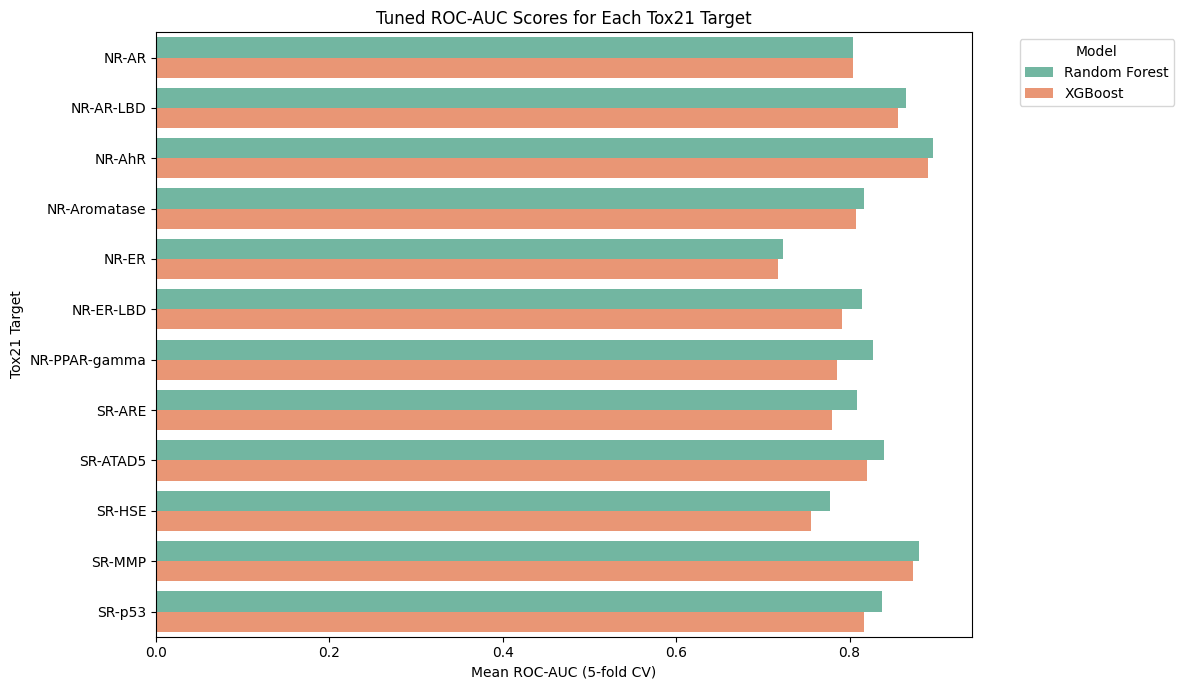

In [38]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parameters and targets ---
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# --- Result collectors ---
tuning_results = []

# --- Loop through targets ---
for target in targets:
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"Skipping {target} due to class imbalance.")
        continue

    print(f"Tuning for target: {target}")

    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=rf_param_grid,
        n_iter=10,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    rf_search.fit(X_clean, y_clean)
    tuning_results.append({
    "Target": target,
    "Model": "Random Forest",
    "ROC_AUC": rf_search.best_score_,
    "Best_Params": rf_search.best_params_
})


    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=xgb_param_grid,
        n_iter=10,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    xgb_search.fit(X_clean, y_clean)
    tuning_results.append({
    "Target": target,
    "Model": "XGBoost",
    "ROC_AUC": xgb_search.best_score_,
    "Best_Params": xgb_search.best_params_
})


# --- Convert results to DataFrame ---
results_df = pd.DataFrame(tuning_results)

# --- Plot ---
plt.figure(figsize=(12, 7))
sns.barplot(data=results_df, x="ROC_AUC", y="Target", hue="Model", palette="Set2")
plt.title("Tuned ROC-AUC Scores for Each Tox21 Target")
plt.xlabel("Mean ROC-AUC (5-fold CV)")
plt.ylabel("Tox21 Target")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [39]:
# --- Print and Save Tuning Results ---
import pandas as pd

pd.set_option("display.max_colwidth", None)  # So full param dicts are visible
print("\n🔍 Sorted Tuning Results by ROC-AUC:\n")
print(results_df.sort_values(by="ROC_AUC", ascending=False))

# Optional: Save to CSV
results_df.to_csv("tox21_model_tuning_results.csv", index=False)
print("\n✅ Results saved to 'tox21_model_tuning_results.csv'")



🔍 Sorted Tuning Results by ROC-AUC:

           Target          Model   ROC_AUC  \
4          NR-AhR  Random Forest  0.896420   
5          NR-AhR        XGBoost  0.890473   
20         SR-MMP  Random Forest  0.880589   
21         SR-MMP        XGBoost  0.873026   
2       NR-AR-LBD  Random Forest  0.865530   
3       NR-AR-LBD        XGBoost  0.855799   
16       SR-ATAD5  Random Forest  0.839462   
22         SR-p53  Random Forest  0.837949   
12  NR-PPAR-gamma  Random Forest  0.826706   
17       SR-ATAD5        XGBoost  0.819906   
6    NR-Aromatase  Random Forest  0.817062   
23         SR-p53        XGBoost  0.816613   
10      NR-ER-LBD  Random Forest  0.814366   
14         SR-ARE  Random Forest  0.809177   
7    NR-Aromatase        XGBoost  0.806935   
1           NR-AR        XGBoost  0.804435   
0           NR-AR  Random Forest  0.803849   
11      NR-ER-LBD        XGBoost  0.791433   
13  NR-PPAR-gamma        XGBoost  0.785996   
15         SR-ARE        XGBoost  0.780225

## Final model test (training + saving)

* Random forest
* XGBoost

In [40]:
from joblib import dump
import os

# Ensure output folder exists
os.makedirs("final_models", exist_ok=True)

# Train best model per target using full data
for result in tuning_results:
    target = result["Target"]
    model_type = result["Model"]
    best_params = result["Best_Params"]

    print(f"\n🚀 Training final {model_type} model for target: {target}")

    # Get data
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"Skipping {target} (not enough class diversity)")
        continue

    # Initialize model with best hyperparameters
    if model_type == "Random Forest":
        final_model = RandomForestClassifier(**best_params, random_state=42)
    elif model_type == "XGBoost":
        final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Train on full data
    final_model.fit(X_clean, y_clean)

    # Save model to disk
    model_filename = f"final_models/{target}_{model_type.replace(' ', '_')}.joblib"
    dump(final_model, model_filename)
    print(f"✅ Model saved to {model_filename}")



🚀 Training final Random Forest model for target: NR-AR
✅ Model saved to final_models/NR-AR_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-AR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-AR_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-AR-LBD
✅ Model saved to final_models/NR-AR-LBD_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-AR-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-AR-LBD_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-AhR
✅ Model saved to final_models/NR-AhR_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-AhR


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:19:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-AhR_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-Aromatase
✅ Model saved to final_models/NR-Aromatase_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-Aromatase


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-Aromatase_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-ER
✅ Model saved to final_models/NR-ER_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-ER


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-ER_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-ER-LBD
✅ Model saved to final_models/NR-ER-LBD_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-ER-LBD


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-ER-LBD_XGBoost.joblib

🚀 Training final Random Forest model for target: NR-PPAR-gamma
✅ Model saved to final_models/NR-PPAR-gamma_Random_Forest.joblib

🚀 Training final XGBoost model for target: NR-PPAR-gamma


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/NR-PPAR-gamma_XGBoost.joblib

🚀 Training final Random Forest model for target: SR-ARE
✅ Model saved to final_models/SR-ARE_Random_Forest.joblib

🚀 Training final XGBoost model for target: SR-ARE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/SR-ARE_XGBoost.joblib

🚀 Training final Random Forest model for target: SR-ATAD5
✅ Model saved to final_models/SR-ATAD5_Random_Forest.joblib

🚀 Training final XGBoost model for target: SR-ATAD5


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/SR-ATAD5_XGBoost.joblib

🚀 Training final Random Forest model for target: SR-HSE
✅ Model saved to final_models/SR-HSE_Random_Forest.joblib

🚀 Training final XGBoost model for target: SR-HSE


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/SR-HSE_XGBoost.joblib

🚀 Training final Random Forest model for target: SR-MMP
✅ Model saved to final_models/SR-MMP_Random_Forest.joblib

🚀 Training final XGBoost model for target: SR-MMP


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/SR-MMP_XGBoost.joblib

🚀 Training final Random Forest model for target: SR-p53
✅ Model saved to final_models/SR-p53_Random_Forest.joblib

🚀 Training final XGBoost model for target: SR-p53


/Users/chrisnjw/.pyenv/versions/tox21-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved to final_models/SR-p53_XGBoost.joblib


```
 What the Code Currently Does

For each target in your Tox21 list, the code:

    1. Loops over tuning_results, which includes:

    * Model type (Random Forest or XGBoost)

    * Target name (e.g., 'NR-AR')

    * ROC-AUC score

    * Best hyperparameters

    For each (target, model_type) pair, it:

    * Retrieves the best hyperparameters.

    * Trains that specific model on all cleaned data for that target.

    * Saves it to a .joblib file.
```